# 😎 Quick-start Tutorials for PyPOTS are Here!

## Dependency Installation

In [ ]:
!pip install https://github.com/WenjieDu/PyPOTS/archive/dev.zip

In [1]:
import pypots

/data/miniconda3/envs/workshop/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 



## 📀 Preparing the **PhysioNet-2012** dataset for this tutorial

In [2]:
import numpy as np
import benchpots
from pypots.utils.random import set_random_seed

set_random_seed()

# Load the PhysioNet-2012 dataset
physionet2012_dataset = benchpots.datasets.preprocess_physionet2012(subset="set-a", pattern="point", rate=0.1)

# Take a look at the generated PhysioNet-2012 dataset, you'll find that everything has been prepared for you,
# data splitting, normalization, additional artificially-missing values for evaluation, etc.
print(physionet2012_dataset.keys())

2025-03-18 11:22:12 [INFO]: Have set the random seed as 2022 for numpy and pytorch.
2025-03-18 11:22:12 [INFO]: You're using dataset physionet_2012, please cite it properly in your work. You can find its reference information at the below link: 
https://github.com/WenjieDu/TSDB/tree/main/dataset_profiles/physionet_2012
2025-03-18 11:22:12 [INFO]: Dataset physionet_2012 has already been downloaded. Processing directly...
2025-03-18 11:22:12 [INFO]: Dataset physionet_2012 has already been cached. Loading from cache directly...
2025-03-18 11:22:12 [INFO]: Loaded successfully!
2025-03-18 11:22:18 [WARNING]: Note that physionet_2012 has sparse observations in the time series, hence we don't add additional missing values to the training dataset. 
2025-03-18 11:22:18 [INFO]: 22880 values masked out in the val set as ground truth, take 10.02% of the original observed values
2025-03-18 11:22:18 [INFO]: 28654 values masked out in the test set as ground truth, take 9.98% of the original observed 

dict_keys(['n_classes', 'n_steps', 'n_features', 'scaler', 'train_X', 'train_y', 'train_ICUType', 'val_X', 'val_y', 'val_ICUType', 'test_X', 'test_y', 'test_ICUType', 'val_X_ori', 'test_X_ori'])


## 🌟 Imputation Models

In [5]:
# assemble the datasets for training
dataset_for_training = {
    "X": physionet2012_dataset['train_X'],
}
# assemble the datasets for validation
dataset_for_validating = {
    "X": physionet2012_dataset['val_X'],
    "X_ori": physionet2012_dataset['val_X_ori'],
}
# assemble the datasets for test
dataset_for_testing = {
    "X": physionet2012_dataset['test_X'],
}
## calculate the mask to indicate the ground truth positions in test_X_ori, will be used by metric funcs to evaluate models
test_X_indicating_mask = np.isnan(physionet2012_dataset['test_X_ori']) ^ np.isnan(physionet2012_dataset['test_X'])
test_X_ori = np.nan_to_num(physionet2012_dataset['test_X_ori'])  # metric functions do not accpet input with NaNs, hence fill NaNs with 0

### 🚀 An example of **SAITS** for imputation

In [ ]:
from pypots.nn.functional import calc_mae
from pypots.optim import Adam
from pypots.imputation import SAITS

# initialize the model
saits = SAITS(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    n_layers=1,
    d_model=256,
    d_ffn=128,
    n_heads=4,
    d_k=64,
    d_v=64,
    dropout=0.1,
    ORT_weight=1,  # you can adjust the weight values of arguments ORT_weight
    # and MIT_weight to make the SAITS model focus more on one task. Usually you can just leave them to the default values, i.e. 1.
    MIT_weight=1,
    batch_size=32,
    # here we set epochs=10 for a quick demo, you can set it to 100 or more for better performance
    epochs=10,
    # here we set patience=3 to early stop the training if the evaluting loss doesn't decrease for 3 epoches.
    # You can leave it to defualt as None to disable early stopping.
    patience=3,
    # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
    # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
    optimizer=Adam(lr=1e-3),
    # this num_workers argument is for torch.utils.data.Dataloader. It's the number of subprocesses to use for data loading.
    # Leaving it to default as 0 means data loading will be in the main process, i.e. there won't be subprocesses.
    # You can increase it to >1 if you think your dataloading is a bottleneck to your model training speed
    num_workers=0,
    # just leave it to default as None, PyPOTS will automatically assign the best device for you.
    # Set it as 'cpu' if you don't have CUDA devices. You can also set it to 'cuda:0' or 'cuda:1' if you have multiple CUDA devices, even parallelly on ['cuda:0', 'cuda:1']
    device=None,
    # set the path for saving tensorboard and trained model files
    saving_path="tutorial_results/imputation/saits",
    # only save the best model after training finished.
    # You can also set it as "better" to save models performing better ever during training.
    model_saving_strategy="best",
)

# train the model on the training set, and validate it on the validating set to select the best model for testing in the next step
saits.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

# the testing stage, impute the originally-missing values and artificially-missing values in the test set
saits_results = saits.predict(dataset_for_testing)
saits_imputation = saits_results["imputation"]

# calculate mean absolute error on the ground truth (artificially-missing values)
testing_mae = calc_mae(
    saits_imputation,
    test_X_ori,
    test_X_indicating_mask,
)
print(f"Testing mean absolute error: {testing_mae:.4f}")


2025-03-18 08:58:21 [WARNING]: ‼️ `pypots.utils.metrics` is deprecated. Please import from `pypots.nn.functional` instead.
2025-03-18 08:58:22 [INFO]: No given device, using default device: cuda
2025-03-18 08:58:22 [INFO]: Model files will be saved to tutorial_results/imputation/saits/20250318_T085822
2025-03-18 08:58:22 [INFO]: Tensorboard file will be saved to tutorial_results/imputation/saits/20250318_T085822/tensorboard
2025-03-18 08:58:22 [INFO]: Using customized MAE as the training loss function.
2025-03-18 08:58:22 [INFO]: Using customized MSE as the validation metric function.
2025-03-18 08:58:22 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 720,182
2025-03-18 08:58:24 [INFO]: Epoch 001 - training loss (MAE): 0.9300, validation MSE: 0.3957
2025-03-18 08:58:25 [INFO]: Epoch 002 - training loss (MAE): 0.6510, validation MSE: 0.3523
2025-03-18 08:58:25 [INFO]: Epoch 003 - training loss (MAE): 0.5865, validation MSE: 0.3411
2025-03-18

Testing mean absolute error: 0.2902


### 🚀 An example of **Transformer** for imputation

In [ ]:
from pypots.optim import Adam
from pypots.imputation import Transformer
from pypots.nn.functional import calc_mae

# initialize the model
transformer = Transformer(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    n_layers=3,
    d_model=512,
    d_ffn=256,
    n_heads=4,
    d_k=128,
    d_v=128,
    dropout=0.1,
    attn_dropout=0,
    ORT_weight=1,  # you can adjust the weight values of arguments ORT_weight
    # and MIT_weight to make the SAITS model focus more on one task. Usually you can just leave them to the default values, i.e. 1.
    MIT_weight=1,
    batch_size=32,
    # here we set epochs=10 for a quick demo, you can set it to 100 or more for better performance
    epochs=10,
    # here we set patience=3 to early stop the training if the evaluting loss doesn't decrease for 3 epoches.
    # You can leave it to defualt as None to disable early stopping.
    patience=3,
    # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
    # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
    optimizer=Adam(lr=1e-3),
    # this num_workers argument is for torch.utils.data.Dataloader. It's the number of subprocesses to use for data loading.
    # Leaving it to default as 0 means data loading will be in the main process, i.e. there won't be subprocesses.
    # You can increase it to >1 if you think your dataloading is a bottleneck to your model training speed
    num_workers=0,
    # just leave it to default as None, PyPOTS will automatically assign the best device for you.
    # Set it as 'cpu' if you don't have CUDA devices. You can also set it to 'cuda:0' or 'cuda:1' if you have multiple CUDA devices, even parallelly on ['cuda:0', 'cuda:1']
    device=None,
    # set the path for saving tensorboard and trained model files
    saving_path="tutorial_results/imputation/transformer",
    # only save the best model after training finished.
    # You can also set it as "better" to save models performing better ever during training.
    model_saving_strategy="best",
)


# train the model on the training set, and validate it on the validating set to select the best model for testing in the next step
transformer.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

# the testing stage, impute the originally-missing values and artificially-missing values in the test set
transformer_results = transformer.predict(dataset_for_testing)
transformer_imputation = transformer_results["imputation"]

# calculate mean absolute error on the ground truth (artificially-missing values)
testing_mae = calc_mae(
    transformer_imputation,
    test_X_ori,
    test_X_indicating_mask,
)
print(f"Testing mean absolute error: {testing_mae:.4f}")


2025-03-18 08:58:31 [INFO]: No given device, using default device: cuda
2025-03-18 08:58:31 [INFO]: Model files will be saved to tutorial_results/imputation/transformer/20250318_T085831
2025-03-18 08:58:31 [INFO]: Tensorboard file will be saved to tutorial_results/imputation/transformer/20250318_T085831/tensorboard
2025-03-18 08:58:31 [INFO]: Using customized MAE as the training loss function.
2025-03-18 08:58:31 [INFO]: Using customized MSE as the validation metric function.
2025-03-18 08:58:31 [INFO]: Transformer initialized with the given hyperparameters, the number of trainable parameters: 3,997,989
2025-03-18 08:58:32 [INFO]: Epoch 001 - training loss (MAE): 1.2109, validation MSE: 0.4247
2025-03-18 08:58:33 [INFO]: Epoch 002 - training loss (MAE): 0.6904, validation MSE: 0.3723
2025-03-18 08:58:34 [INFO]: Epoch 003 - training loss (MAE): 0.6154, validation MSE: 0.3667
2025-03-18 08:58:34 [INFO]: Epoch 004 - training loss (MAE): 0.5691, validation MSE: 0.3298
2025-03-18 08:58:35 [

Testing mean absolute error: 0.2901


### 🚀 An example of **TimesNet** for imputation

In [ ]:
from pypots.optim import Adam
from pypots.imputation import TimesNet
from pypots.nn.functional import calc_mae

# initialize the model
timesnet = TimesNet(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    n_layers=1,
    top_k=1,
    d_model=128,
    d_ffn=512,
    n_kernels=5,
    dropout=0.5,
    apply_nonstationary_norm=False,
    batch_size=32,
    # here we set epochs=10 for a quick demo, you can set it to 100 or more for better performance
    epochs=10,
    # here we set patience=3 to early stop the training if the evaluting loss doesn't decrease for 3 epoches.
    # You can leave it to defualt as None to disable early stopping.
    patience=3,
    # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
    # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
    optimizer=Adam(lr=1e-3),
    # this num_workers argument is for torch.utils.data.Dataloader. It's the number of subprocesses to use for data loading.
    # Leaving it to default as 0 means data loading will be in the main process, i.e. there won't be subprocesses.
    # You can increase it to >1 if you think your dataloading is a bottleneck to your model training speed
    num_workers=0,
    # just leave it to default as None, PyPOTS will automatically assign the best device for you.
    # Set it as 'cpu' if you don't have CUDA devices. You can also set it to 'cuda:0' or 'cuda:1' if you have multiple CUDA devices, even parallelly on ['cuda:0', 'cuda:1']
    device=None,
    # set the path for saving tensorboard and trained model files
    saving_path="tutorial_results/imputation/timesnet",
    # only save the best model after training finished.
    # You can also set it as "better" to save models performing better ever during training.
    model_saving_strategy="best",
)


# train the model on the training set, and validate it on the validating set to select the best model for testing in the next step
timesnet.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

# the testing stage, impute the originally-missing values and artificially-missing values in the test set
timesnet_results = timesnet.predict(dataset_for_testing)
timesnet_imputation = timesnet_results["imputation"]

# calculate mean absolute error on the ground truth (artificially-missing values)
testing_mae = calc_mae(
    timesnet_imputation,
    test_X_ori,
    test_X_indicating_mask,
)
print(f"Testing mean absolute error: {testing_mae:.4f}")


2025-03-18 08:58:39 [INFO]: No given device, using default device: cuda
2025-03-18 08:58:39 [INFO]: Model files will be saved to tutorial_results/imputation/timesnet/20250318_T085839
2025-03-18 08:58:39 [INFO]: Tensorboard file will be saved to tutorial_results/imputation/timesnet/20250318_T085839/tensorboard
2025-03-18 08:58:39 [INFO]: Using customized MAE as the training loss function.
2025-03-18 08:58:39 [INFO]: Using customized MSE as the validation metric function.
2025-03-18 08:58:40 [INFO]: TimesNet initialized with the given hyperparameters, the number of trainable parameters: 21,649,573
2025-03-18 08:58:45 [INFO]: Epoch 001 - training loss (MAE): 0.4906, validation MSE: 0.4071
2025-03-18 08:58:46 [INFO]: Epoch 002 - training loss (MAE): 0.4066, validation MSE: 0.3826
2025-03-18 08:58:47 [INFO]: Epoch 003 - training loss (MAE): 0.3916, validation MSE: 0.3700
2025-03-18 08:58:48 [INFO]: Epoch 004 - training loss (MAE): 0.3878, validation MSE: 0.3554
2025-03-18 08:58:49 [INFO]: E

Testing mean absolute error: 0.3431


### 🚀 An example of **CSDI** for imputation

In [ ]:
from pypots.optim import Adam
from pypots.imputation import CSDI
from pypots.nn.functional import calc_mae

# initialize the model
csdi = CSDI(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    n_layers=6,
    n_heads=2,
    n_channels=128,
    d_time_embedding=64,
    d_feature_embedding=32,
    d_diffusion_embedding=128,
    target_strategy="random",
    n_diffusion_steps=50,
    batch_size=32,
    # here we set epochs=10 for a quick demo, you can set it to 100 or more for better performance
    epochs=10,
    # here we set patience=3 to early stop the training if the evaluting loss doesn't decrease for 3 epoches.
    # You can leave it to defualt as None to disable early stopping.
    patience=3,
    # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
    # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
    optimizer=Adam(lr=1e-3),
    # this num_workers argument is for torch.utils.data.Dataloader. It's the number of subprocesses to use for data loading.
    # Leaving it to default as 0 means data loading will be in the main process, i.e. there won't be subprocesses.
    # You can increase it to >1 if you think your dataloading is a bottleneck to your model training speed
    num_workers=0,
    # just leave it to default as None, PyPOTS will automatically assign the best device for you.
    # Set it as 'cpu' if you don't have CUDA devices. You can also set it to 'cuda:0' or 'cuda:1' if you have multiple CUDA devices, even parallelly on ['cuda:0', 'cuda:1']
    device=None,
    # set the path for saving tensorboard and trained model files
    saving_path="tutorial_results/imputation/csdi",
    # only save the best model after training finished.
    # You can also set it as "better" to save models performing better ever during training.
    model_saving_strategy="best",
)


# train the model on the training set, and validate it on the validating set to select the best model for testing in the next step
csdi.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

# the testing stage, impute the originally-missing values and artificially-missing values in the test set

# CSDI has an argument to control the number of sampling times during inference
csdi_results = csdi.predict(dataset_for_testing, n_sampling_times=2)
csdi_imputation = csdi_results["imputation"]

print(f"The shape of csdi_imputation is {csdi_imputation.shape}")

# for error calculation, we need to take the mean value of the multiple samplings for each data sample
mean_csdi_imputation = csdi_imputation.mean(axis=1)

# calculate mean absolute error on the ground truth (artificially-missing values)
testing_mae = calc_mae(
    mean_csdi_imputation,
    test_X_ori,
    test_X_indicating_mask,
)
print(f"Testing mean absolute error: {testing_mae:.4f}")


2025-03-18 08:58:54 [INFO]: No given device, using default device: cuda
2025-03-18 08:58:54 [INFO]: Model files will be saved to tutorial_results/imputation/csdi/20250318_T085854
2025-03-18 08:58:54 [INFO]: Tensorboard file will be saved to tutorial_results/imputation/csdi/20250318_T085854/tensorboard
/data/miniconda3/envs/workshop/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
2025-03-18 08:58:55 [INFO]: CSDI initialized with the given hyperparameters, the number of trainable parameters: 1,694,753
2025-03-18 08:59:33 [INFO]: Epoch 001 - training loss (default): 0.4213, validation metric (default): 0.3410
2025-03-18 09:00:12 [INFO]: Epoch 002 - training loss (default): 0.3183, validation metric (default): 0.2973
2025-03-18 09:00:51 [INFO]: Epoch 003 - training loss (d

The shape of csdi_imputation is (800, 2, 48, 37)
Testing mean absolute error: 0.3183


### 🚀 An example of **US-GAN** for imputation

In [ ]:
from pypots.optim import Adam
from pypots.imputation import USGAN
from pypots.nn.functional import calc_mae

# initialize the model
us_gan = USGAN(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    rnn_hidden_size=256,
    lambda_mse=1,
    dropout=0.1,
    G_steps=1,
    D_steps=1,
    batch_size=32,
    # here we set epochs=10 for a quick demo, you can set it to 100 or more for better performance
    epochs=10,
    # here we set patience=3 to early stop the training if the evaluting loss doesn't decrease for 3 epoches.
    # You can leave it to defualt as None to disable early stopping.
    patience=3,
    # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
    # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
    G_optimizer=Adam(lr=1e-3),
    D_optimizer=Adam(lr=1e-3),
    # this num_workers argument is for torch.utils.data.Dataloader. It's the number of subprocesses to use for data loading.
    # Leaving it to default as 0 means data loading will be in the main process, i.e. there won't be subprocesses.
    # You can increase it to >1 if you think your dataloading is a bottleneck to your model training speed
    num_workers=0,
    # just leave it to default as None, PyPOTS will automatically assign the best device for you.
    # Set it as 'cpu' if you don't have CUDA devices. You can also set it to 'cuda:0' or 'cuda:1' if you have multiple CUDA devices, even parallelly on ['cuda:0', 'cuda:1']
    device=None,
    # set the path for saving tensorboard and trained model files
    saving_path="tutorial_results/imputation/us_gan",
    # only save the best model after training finished.
    # You can also set it as "better" to save models performing better ever during training.
    model_saving_strategy="best",
)


# train the model on the training set, and validate it on the validating set to select the best model for testing in the next step
us_gan.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

# the testing stage, impute the originally-missing values and artificially-missing values in the test set
us_gan_results = us_gan.predict(dataset_for_testing)
us_gan_imputation = us_gan_results["imputation"]

# calculate mean absolute error on the ground truth (artificially-missing values)
testing_mae = calc_mae(
    us_gan_imputation,
    test_X_ori,
    test_X_indicating_mask,
)
print(f"Testing mean absolute error: {testing_mae:.4f}")


2025-03-18 09:06:40 [INFO]: No given device, using default device: cuda
2025-03-18 09:06:40 [INFO]: Model files will be saved to tutorial_results/imputation/us_gan/20250318_T090640
2025-03-18 09:06:40 [INFO]: Tensorboard file will be saved to tutorial_results/imputation/us_gan/20250318_T090640/tensorboard
2025-03-18 09:06:40 [INFO]: USGAN initialized with the given hyperparameters, the number of trainable parameters: 1,258,517
2025-03-18 09:07:06 [INFO]: Epoch 001 - generator training loss: 0.5029, discriminator training loss: 0.3133, validation loss: 0.4255
2025-03-18 09:07:28 [INFO]: Epoch 002 - generator training loss: 0.4076, discriminator training loss: 0.1539, validation loss: 0.3910
2025-03-18 09:07:50 [INFO]: Epoch 003 - generator training loss: 0.4065, discriminator training loss: 0.0873, validation loss: 0.3649
2025-03-18 09:08:12 [INFO]: Epoch 004 - generator training loss: 0.3895, discriminator training loss: 0.0631, validation loss: 0.3437
2025-03-18 09:08:34 [INFO]: Epoch

Testing mean absolute error: 0.3272


### 🚀 An example of **GP-VAE** for imputation

In [ ]:
from pypots.optim import Adam
from pypots.imputation import GPVAE
from pypots.nn.functional import calc_mae


# initialize the model
gp_vae = GPVAE(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    latent_size=37,
    encoder_sizes=(128,128),
    decoder_sizes=(256,256),
    kernel="cauchy",
    beta=0.2,
    M=1,
    K=1,
    sigma=1.005,
    length_scale=7.0,
    kernel_scales=1,
    window_size=24,
    batch_size=32,
    # here we set epochs=10 for a quick demo, you can set it to 100 or more for better performance
    epochs=10,
    # here we set patience=3 to early stop the training if the evaluting loss doesn't decrease for 3 epoches.
    # You can leave it to defualt as None to disable early stopping.
    patience=3,
    # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
    # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
    optimizer=Adam(lr=1e-3),
    # this num_workers argument is for torch.utils.data.Dataloader. It's the number of subprocesses to use for data loading.
    # Leaving it to default as 0 means data loading will be in the main process, i.e. there won't be subprocesses.
    # You can increase it to >1 if you think your dataloading is a bottleneck to your model training speed
    num_workers=0,
    # just leave it to default as None, PyPOTS will automatically assign the best device for you.
    # Set it as 'cpu' if you don't have CUDA devices. You can also set it to 'cuda:0' or 'cuda:1' if you have multiple CUDA devices, even parallelly on ['cuda:0', 'cuda:1']
    device=None,
    # set the path for saving tensorboard and trained model files
    saving_path="tutorial_results/imputation/gp_vae",
    # only save the best model after training finished.
    # You can also set it as "better" to save models performing better ever during training.
    model_saving_strategy="best",
)

# train the model on the training set, and validate it on the validating set to select the best model for testing in the next step
gp_vae.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

# the testing stage, impute the originally-missing values and artificially-missing values in the test set

# GP-VAE has an argument to control the number of sampling times during inference
gp_vae_results = gp_vae.predict(dataset_for_testing, n_sampling_times=2)
gp_vae_imputation = gp_vae_results["imputation"]

print(f"The shape of gp_vae_imputation is {gp_vae_imputation.shape}")

# for error calculation, we need to take the mean value of the multiple samplings for each data sample
mean_gp_vae_imputation = gp_vae_imputation.mean(axis=1)

# calculate mean absolute error on the ground truth (artificially-missing values)
testing_mae = calc_mae(
    mean_gp_vae_imputation,
    test_X_ori,
    test_X_indicating_mask,
)
print(f"Testing mean absolute error: {testing_mae:.4f}")


2025-03-18 09:10:20 [INFO]: No given device, using default device: cuda
2025-03-18 09:10:20 [INFO]: Model files will be saved to tutorial_results/imputation/gp_vae/20250318_T091020
2025-03-18 09:10:20 [INFO]: Tensorboard file will be saved to tutorial_results/imputation/gp_vae/20250318_T091020/tensorboard
2025-03-18 09:10:20 [INFO]: GPVAE initialized with the given hyperparameters, the number of trainable parameters: 229,652
2025-03-18 09:10:21 [INFO]: Epoch 001 - training loss (NoneType): 32210.9857, validation NoneType: 0.6154
2025-03-18 09:10:22 [INFO]: Epoch 002 - training loss (NoneType): 23158.1282, validation NoneType: 0.6062
2025-03-18 09:10:23 [INFO]: Epoch 003 - training loss (NoneType): 22965.8687, validation NoneType: 0.6015
2025-03-18 09:10:23 [INFO]: Epoch 004 - training loss (NoneType): 22895.7626, validation NoneType: 0.6045
2025-03-18 09:10:24 [INFO]: Epoch 005 - training loss (NoneType): 22867.6528, validation NoneType: 0.5943
2025-03-18 09:10:25 [INFO]: Epoch 006 - t

The shape of gp_vae_imputation is (800, 2, 48, 37)
Testing mean absolute error: 0.5201


### 🚀 An example of **BRITS** for imputation

In [ ]:
from pypots.optim import Adam
from pypots.imputation import BRITS
from pypots.nn.functional import calc_mae

# initialize the model
brits = BRITS(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    rnn_hidden_size=128,
    batch_size=32,
    # here we set epochs=10 for a quick demo, you can set it to 100 or more for better performance
    epochs=10,
    # here we set patience=3 to early stop the training if the evaluting loss doesn't decrease for 3 epoches.
    # You can leave it to defualt as None to disable early stopping.
    patience=3,
    # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
    # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
    optimizer=Adam(lr=1e-3),
    # this num_workers argument is for torch.utils.data.Dataloader. It's the number of subprocesses to use for data loading.
    # Leaving it to default as 0 means data loading will be in the main process, i.e. there won't be subprocesses.
    # You can increase it to >1 if you think your dataloading is a bottleneck to your model training speed
    num_workers=0,
    # just leave it to default as None, PyPOTS will automatically assign the best device for you.
    # Set it as 'cpu' if you don't have CUDA devices. You can also set it to 'cuda:0' or 'cuda:1' if you have multiple CUDA devices, even parallelly on ['cuda:0', 'cuda:1']
    device=None,
    # set the path for saving tensorboard and trained model files
    saving_path="tutorial_results/imputation/brits",
    # only save the best model after training finished.
    # You can also set it as "better" to save models performing better ever during training.
    model_saving_strategy="best",
)

# train the model on the training set, and validate it on the validating set to select the best model for testing in the next step
brits.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

# the testing stage, impute the originally-missing values and artificially-missing values in the test set
brits_results = brits.predict(dataset_for_testing)
brits_imputation = brits_results["imputation"]

# calculate mean absolute error on the ground truth (artificially-missing values)
testing_mae = calc_mae(
    brits_imputation,
    test_X_ori,
    test_X_indicating_mask,
)
print(f"Testing mean absolute error: {testing_mae:.4f}")


2025-03-18 09:10:28 [INFO]: No given device, using default device: cuda
2025-03-18 09:10:28 [INFO]: Model files will be saved to tutorial_results/imputation/brits/20250318_T091028
2025-03-18 09:10:28 [INFO]: Tensorboard file will be saved to tutorial_results/imputation/brits/20250318_T091028/tensorboard
2025-03-18 09:10:28 [INFO]: Using customized MAE as the training loss function.
2025-03-18 09:10:28 [INFO]: Using customized MSE as the validation metric function.
2025-03-18 09:10:28 [INFO]: BRITS initialized with the given hyperparameters, the number of trainable parameters: 239,344
2025-03-18 09:10:46 [INFO]: Epoch 001 - training loss (MAE): 1.1426, validation MSE: 0.4710
2025-03-18 09:11:02 [INFO]: Epoch 002 - training loss (MAE): 0.8812, validation MSE: 0.4019
2025-03-18 09:11:17 [INFO]: Epoch 003 - training loss (MAE): 0.8085, validation MSE: 0.3653
2025-03-18 09:11:32 [INFO]: Epoch 004 - training loss (MAE): 0.7641, validation MSE: 0.3371
2025-03-18 09:11:48 [INFO]: Epoch 005 - t

Testing mean absolute error: 0.2920


### 🚀 An example of **M-RNN** for imputation

In [ ]:
from pypots.optim import Adam
from pypots.imputation import MRNN
from pypots.nn.functional import calc_mae

# initialize the model
# initialize the model
mrnn = MRNN(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    rnn_hidden_size=128,

    # here we set epochs=10 for a quick demo, you can set it to 100 or more for better performance
    epochs=10,
    # here we set patience=3 to early stop the training if the evaluting loss doesn't decrease for 3 epoches.
    # You can leave it to defualt as None to disable early stopping.
    patience=3,
    # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
    # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
    optimizer=Adam(lr=1e-3),
    # this num_workers argument is for torch.utils.data.Dataloader. It's the number of subprocesses to use for data loading.
    # Leaving it to default as 0 means data loading will be in the main process, i.e. there won't be subprocesses.
    # You can increase it to >1 if you think your dataloading is a bottleneck to your model training speed
    num_workers=0,
    # just leave it to default as None, PyPOTS will automatically assign the best device for you.
    # Set it as 'cpu' if you don't have CUDA devices. You can also set it to 'cuda:0' or 'cuda:1' if you have multiple CUDA devices, even parallelly on ['cuda:0', 'cuda:1']
    device=None,
    # set the path for saving tensorboard and trained model files
    saving_path="tutorial_results/imputation/mrnn",
    # only save the best model after training finished.
    # You can also set it as "better" to save models performing better ever during training.
    model_saving_strategy="best",
)

# train the model on the training set, and validate it on the validating set to select the best model for testing in the next step
mrnn.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

# the testing stage, impute the originally-missing values and artificially-missing values in the test set
mrnn_results = mrnn.predict(dataset_for_testing)
mrnn_imputation = mrnn_results["imputation"]

# calculate mean absolute error on the ground truth (artificially-missing values)
testing_mae = calc_mae(
    mrnn_imputation,
    test_X_ori,
    test_X_indicating_mask,
)
print(f"Testing mean absolute error: {testing_mae:.4f}")


2025-03-18 09:13:07 [INFO]: No given device, using default device: cuda
2025-03-18 09:13:07 [INFO]: Model files will be saved to tutorial_results/imputation/mrnn/20250318_T091307
2025-03-18 09:13:07 [INFO]: Tensorboard file will be saved to tutorial_results/imputation/mrnn/20250318_T091307/tensorboard
2025-03-18 09:13:07 [INFO]: Using customized RMSE as the training loss function.
2025-03-18 09:13:07 [INFO]: Using customized MSE as the validation metric function.
2025-03-18 09:13:07 [INFO]: MRNN initialized with the given hyperparameters, the number of trainable parameters: 107,951
2025-03-18 09:13:14 [INFO]: Epoch 001 - training loss (RMSE): 1.1120, validation MSE: 0.9538
2025-03-18 09:13:19 [INFO]: Epoch 002 - training loss (RMSE): 0.6179, validation MSE: 0.9220
2025-03-18 09:13:22 [INFO]: Epoch 003 - training loss (RMSE): 0.5768, validation MSE: 0.8962
2025-03-18 09:13:27 [INFO]: Epoch 004 - training loss (RMSE): 0.5403, validation MSE: 0.8776
2025-03-18 09:13:31 [INFO]: Epoch 005 -

Testing mean absolute error: 0.6925


### 🚀 An example of **LOCF** for imputation

In [16]:
from pypots.imputation import LOCF
from pypots.nn.functional import calc_mae

from pypots.imputation import LOCF

# initialize the model
locf = LOCF()

# LOCF doesn't need to be trained, just call the impute() function
locf.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

# the testing stage, impute the originally-missing values and artificially-missing values in the test set
locf_results = locf.predict(dataset_for_testing)
locf_imputation = locf_results["imputation"]

# calculate mean absolute error on the ground truth (artificially-missing values)
testing_mae = calc_mae(
    locf_imputation,
    test_X_ori,
    test_X_indicating_mask,
)
print(f"Testing mean absolute error: {testing_mae:.4f}")


2025-03-18 09:17:51 [INFO]: No given device, using default device: cuda


Testing mean absolute error: 0.4183


/data/miniconda3/envs/workshop/lib/python3.12/site-packages/pypots/imputation/locf/model.py:67: UserWarning: LOCF (Last Observed Carried Forward) imputation class has no parameter to train. Please run func `predict()` directly.
  warnings.warn(


## 🌟 Clustering Models

In [3]:
# Assemble the datasets for training, validating, and testing.
import numpy as np

# don't need validation set
dataset_for_training = {
    "X": np.concatenate([physionet2012_dataset['train_X'], physionet2012_dataset['val_X']], axis=0),
    "y": np.concatenate([physionet2012_dataset['train_y'], physionet2012_dataset['val_y']], axis=0),
}

dataset_for_testing = {
    "X": physionet2012_dataset['test_X'],
    "y": physionet2012_dataset['test_y'],
}


### 🚀 An example of **CRLI** for clustering

In [4]:
from pypots.optim import Adam
from pypots.clustering import CRLI
from pypots.utils.metrics import calc_rand_index, calc_cluster_purity

# initialize the model
crli = CRLI(
    n_steps=physionet2012_dataset["n_steps"],
    n_features=physionet2012_dataset["n_features"],
    n_clusters=physionet2012_dataset["n_classes"],
    n_generator_layers=2,
    rnn_hidden_size=256,
    rnn_cell_type="GRU",
    decoder_fcn_output_dims=[256, 128],  # the output dimensions of layers in the decoder FCN.
    # Here means there are 3 layers. Leave it to default as None will results in
    # the FCN haveing only one layer.
    batch_size=32,
    # here we set epochs=10 for a quick demo, you can set it to 100 or more for better performance
    epochs=10,
    # here we set patience=3 to early stop the training if the evaluting loss doesn't decrease for 3 epoches.
    # You can leave it to defualt as None to disable early stopping.
    patience=3,
    # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
    # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
    G_optimizer=Adam(lr=1e-3),
    D_optimizer=Adam(lr=1e-3),
    # this num_workers argument is for torch.utils.data.Dataloader. It's the number of subprocesses to use for data loading.
    # Leaving it to default as 0 means data loading will be in the main process, i.e. there won't be subprocesses.
    # You can increase it to >1 if you think your dataloading is a bottleneck to your model training speed
    num_workers=0,
    # just leave it to default as None, PyPOTS will automatically assign the best device for you.
    # Set it as 'cpu' if you don't have CUDA devices. You can also set it to 'cuda:0' or 'cuda:1' if you have multiple CUDA devices, even parallelly on ['cuda:0', 'cuda:1']
    device=None,
    # set the path for saving tensorboard and trained model files
    saving_path="tutorial_results/clustering/crli",
    # only save the best model after training finished.
    # You can also set it as "better" to save models performing better ever during training.
    model_saving_strategy="best",
)

# train the model on the training set, and validate it on the validating set to select the best model for testing in the next step
crli.fit(train_set=dataset_for_training)

# the testing stage
crli_results = crli.predict(dataset_for_testing)
crli_clustering = crli_results["clustering"]

# calculate the values of clustering metrics on the model's prediction
RI = calc_rand_index(crli_clustering, dataset_for_testing["y"])
CP = calc_cluster_purity(crli_clustering, dataset_for_testing["y"])

print("Testing clustering metrics: \n"
      f'RI: {RI}, \n'
      f'CP: {CP}\n'
)


2025-03-18 09:27:47 [WARNING]: ‼️ `pypots.utils.metrics` is deprecated. Please import from `pypots.nn.functional` instead.
2025-03-18 09:27:49 [INFO]: No given device, using default device: cuda
2025-03-18 09:27:49 [INFO]: Model files will be saved to tutorial_results/clustering/crli/20250318_T092749
2025-03-18 09:27:49 [INFO]: Tensorboard file will be saved to tutorial_results/clustering/crli/20250318_T092749/tensorboard
2025-03-18 09:27:49 [INFO]: CRLI initialized with the given hyperparameters, the number of trainable parameters: 1,546,820
2025-03-18 09:28:13 [INFO]: Epoch 001 - generator training loss: 2.8936, discriminator training loss: 0.4627
2025-03-18 09:28:35 [INFO]: Epoch 002 - generator training loss: 3.1197, discriminator training loss: 0.4078
2025-03-18 09:28:57 [INFO]: Epoch 003 - generator training loss: 3.2158, discriminator training loss: 0.3884
2025-03-18 09:29:20 [INFO]: Epoch 004 - generator training loss: 3.2620, discriminator training loss: 0.3784
2025-03-18 09:2

Testing clustering metrics: 
RI: 0.499386733416771, 
CP: 0.86125



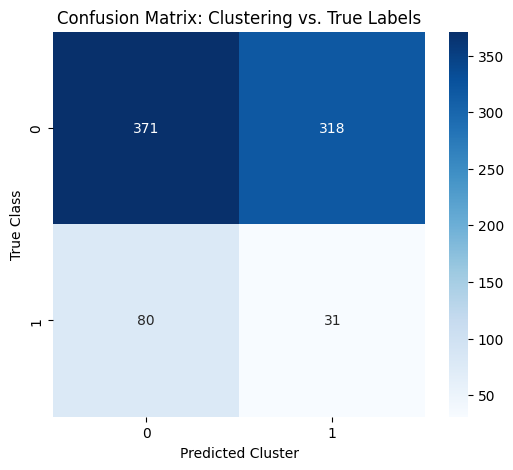

Classification Report:
               precision    recall  f1-score   support
0              0.822616  0.538462  0.650877  689.0000
1              0.088825  0.279279  0.134783  111.0000
accuracy       0.502500  0.502500  0.502500    0.5025
macro avg      0.455721  0.408870  0.392830  800.0000
weighted avg   0.720803  0.502500  0.579269  800.0000
Adjusted Rand Index (ARI): -0.0091


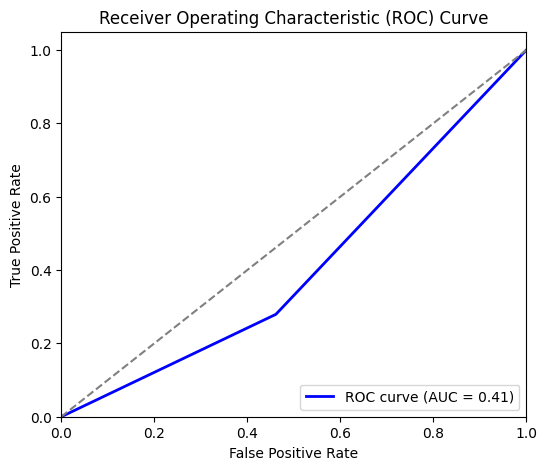

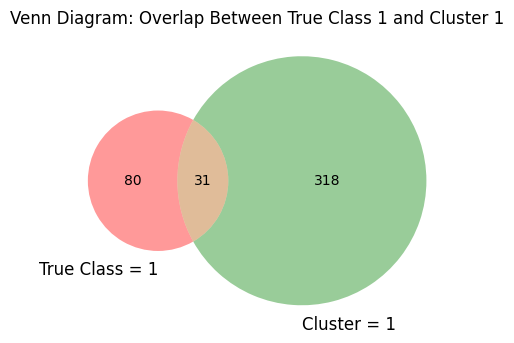

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, adjusted_rand_score
import pandas as pd
from sklearn.metrics import roc_curve, auc
from matplotlib_venn import venn2

true_labels = np.array(dataset_for_testing["y"]).flatten()
cluster_labels = np.array(crli_clustering).flatten()

# calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, cluster_labels)

# plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted Cluster")
plt.ylabel("True Class")
plt.title("Confusion Matrix: Clustering vs. True Labels")
plt.show()

# calculate the classification report
report = classification_report(true_labels, cluster_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("Classification Report:\n", report_df)

# calculate the Adjusted Rand Index
ari_score = adjusted_rand_score(true_labels, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

# calculate roc curve
fpr, tpr, _ = roc_curve(true_labels, cluster_labels)
roc_auc = auc(fpr, tpr)

# plot roc curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# calculate set intersections
set_true_1 = set(np.where(true_labels == 1)[0])  # index of true class=1
set_cluster_1 = set(np.where(cluster_labels == 1)[0])  # index of cluster=1

# plot Venn Diagram
plt.figure(figsize=(5, 5))
venn2([set_true_1, set_cluster_1], ('True Class = 1', 'Cluster = 1'))
plt.title('Venn Diagram: Overlap Between True Class 1 and Cluster 1')
plt.show()

### 🚀 An example of **VaDER** for clustering

In [14]:
from pypots.optim import Adam
from pypots.clustering import VaDER
from pypots.utils.metrics import calc_rand_index, calc_cluster_purity

# initialize the model
vader = VaDER(
    n_steps=physionet2012_dataset["n_steps"],
    n_features=physionet2012_dataset["n_features"],
    n_clusters=physionet2012_dataset["n_classes"],
    rnn_hidden_size=128,
    d_mu_stddev=2,
    pretrain_epochs=20,
    batch_size=32,
    # here we set epochs=10 for a quick demo, you can set it to 100 or more for better performance
    epochs=10,
    # here we set patience=3 to early stop the training if the evaluting loss doesn't decrease for 3 epoches.
    # You can leave it to defualt as None to disable early stopping.
    patience=3,
    # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
    # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
    optimizer=Adam(lr=1e-3),
    # this num_workers argument is for torch.utils.data.Dataloader. It's the number of subprocesses to use for data loading.
    # Leaving it to default as 0 means data loading will be in the main process, i.e. there won't be subprocesses.
    # You can increase it to >1 if you think your dataloading is a bottleneck to your model training speed
    num_workers=0,
    # just leave it to default as None, PyPOTS will automatically assign the best device for you.
    # Set it as 'cpu' if you don't have CUDA devices. You can also set it to 'cuda:0' or 'cuda:1' if you have multiple CUDA devices, even parallelly on ['cuda:0', 'cuda:1']
    device=None,
    # set the path for saving tensorboard and trained model files
    saving_path="tutorial_results/clustering/vader",
    # only save the best model after training finished.
    # You can also set it as "better" to save models performing better ever during training.
    model_saving_strategy="best",
)

# train the model on the training set, and validate it on the validating set to select the best model for testing in the next step
vader.fit(train_set=dataset_for_training)

# the testing stage
vader_results = vader.predict(dataset_for_testing)
vader_clustering = vader_results["clustering"]

# calculate the values of clustering metrics on the model's prediction
RI = calc_rand_index(vader_clustering, dataset_for_testing["y"])
CP = calc_cluster_purity(vader_clustering, dataset_for_testing["y"])

print("Testing clustering metrics: \n"
      f'RI: {RI}, \n'
      f'CP: {CP},\n'
)

2025-03-18 09:46:13 [INFO]: No given device, using default device: cuda
2025-03-18 09:46:13 [INFO]: Model files will be saved to tutorial_results/clustering/vader/20250318_T094613
2025-03-18 09:46:13 [INFO]: Tensorboard file will be saved to tutorial_results/clustering/vader/20250318_T094613/tensorboard
2025-03-18 09:46:13 [INFO]: VaDER initialized with the given hyperparameters, the number of trainable parameters: 293,644
2025-03-18 09:49:20 [INFO]: Epoch 001 - training loss (default): 167.9234
2025-03-18 09:49:28 [INFO]: Epoch 002 - training loss (default): 142.5946
2025-03-18 09:49:37 [INFO]: Epoch 003 - training loss (default): 144.9003
2025-03-18 09:49:46 [INFO]: Epoch 004 - training loss (default): 143.8211
2025-03-18 09:49:54 [INFO]: Epoch 005 - training loss (default): 142.0875
2025-03-18 09:50:02 [INFO]: Epoch 006 - training loss (default): 139.6002
2025-03-18 09:50:11 [INFO]: Epoch 007 - training loss (default): 139.5562
2025-03-18 09:50:19 [INFO]: Epoch 008 - training loss (

Testing clustering metrics: 
RI: 0.6781007509386734, 
CP: 0.86125,



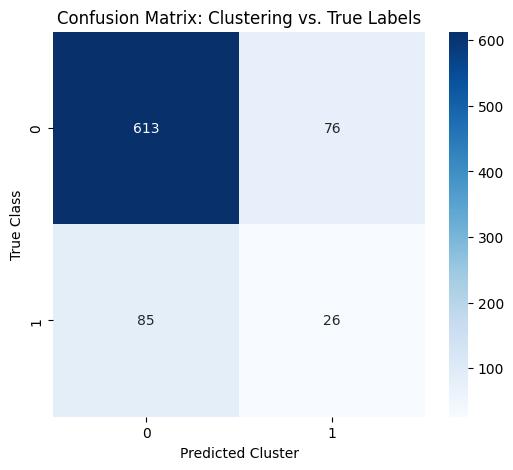

Classification Report:
               precision    recall  f1-score    support
0              0.878223  0.889695  0.883922  689.00000
1              0.254902  0.234234  0.244131  111.00000
accuracy       0.798750  0.798750  0.798750    0.79875
macro avg      0.566563  0.561965  0.564027  800.00000
weighted avg   0.791738  0.798750  0.795151  800.00000
Adjusted Rand Index (ARI): 0.0944


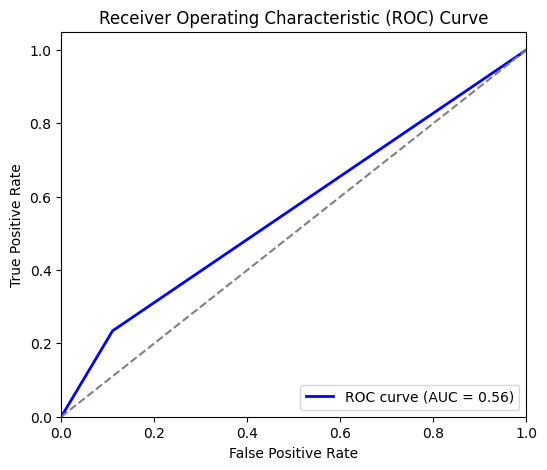

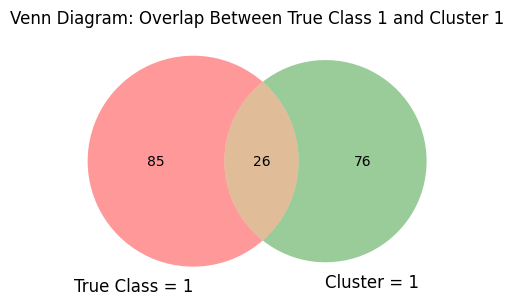

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, adjusted_rand_score
import pandas as pd
from sklearn.metrics import roc_curve, auc
from matplotlib_venn import venn2

true_labels = np.array(dataset_for_testing["y"]).flatten()
cluster_labels = np.array(vader_clustering).flatten()

# calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, cluster_labels)

# plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted Cluster")
plt.ylabel("True Class")
plt.title("Confusion Matrix: Clustering vs. True Labels")
plt.show()

# calculate the classification report
report = classification_report(true_labels, cluster_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("Classification Report:\n", report_df)

# calculate the Adjusted Rand Index
ari_score = adjusted_rand_score(true_labels, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

# calculate roc curve
fpr, tpr, _ = roc_curve(true_labels, cluster_labels)
roc_auc = auc(fpr, tpr)

# plot roc curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# calculate set intersections
set_true_1 = set(np.where(true_labels == 1)[0])  # index of true class=1
set_cluster_1 = set(np.where(cluster_labels == 1)[0])  # index of cluster=1

# plot Venn Diagram
plt.figure(figsize=(5, 5))
venn2([set_true_1, set_cluster_1], ('True Class = 1', 'Cluster = 1'))
plt.title('Venn Diagram: Overlap Between True Class 1 and Cluster 1')
plt.show()

## 🌟 Forecasting Models

In [16]:
# Assemble the datasets for training, validating, and testing.

dataset_for_training = {
    "X": physionet2012_dataset['train_X'],
}

dataset_for_validating = {
    "X": physionet2012_dataset['val_X'],
    "X_intact": physionet2012_dataset['val_X_ori'],
}

dataset_for_testing = {
    "X": physionet2012_dataset['test_X'][:, :36],  # we only take the first 36 steps for model input,
    # and let the model forecast the left 12 steps
}


### 🚀 An example of **BTTF** for forecasting

In [ ]:
from pypots.forecasting import BTTF
from pypots.nn.functional import calc_mae

# initialize the model
bttf = BTTF(
    36,
    physionet2012_dataset["n_features"],
    pred_step=12,
    rank=10,
    time_lags=[1, 2, 3, 10, 10 + 1, 10 + 2, 20, 20 + 1, 20 + 2],
    burn_iter=5,
    gibbs_iter=5,
    multi_step=1,
)

# train the model on the training set, and validate it on the validating set to select the best model for testing in the next step
bttf.fit(train_set=dataset_for_training, val_set=dataset_for_validating)
# BTTF does not need to run func fits().

# the testing stage
bttf_results = bttf.predict(dataset_for_testing)
bttf_prediction = bttf_results["forecasting"]

# calculate the mean absolute error on the ground truth in the forecasting task
testing_mae = calc_mae(
    bttf_prediction,
    np.nan_to_num(physionet2012_dataset['test_X'][:, 36:]),
    (~np.isnan(physionet2012_dataset['test_X'][:, 36:])).astype(int),
)
print(f"Testing mean absolute error: {testing_mae:.4f}")


2025-03-18 09:52:13 [INFO]: No given device, using default device: cuda
2025-03-18 09:52:13 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
/data/miniconda3/envs/workshop/lib/python3.12/site-packages/pypots/forecasting/bttf/model.py:101: UserWarning: Please run func forecast(X) directly.
  warnings.warn("Please run func forecast(X) directly.")


Testing mean absolute error: 0.9022


## 🌟 Classification Models

In [3]:
# Assemble the datasets for training, validating, and testing.

dataset_for_training = {
    "X": physionet2012_dataset['train_X'],
    "y": physionet2012_dataset['train_y'],
}

dataset_for_validating = {
    "X": physionet2012_dataset['val_X'],
    "y": physionet2012_dataset['val_y'],
}

dataset_for_testing = {
    "X": physionet2012_dataset['test_X'],
    "y": physionet2012_dataset['test_y'],
}

### 🚀 An example of **BRITS** for classification

In [4]:
from pypots.optim import Adam
from pypots.classification import BRITS
from pypots.nn.functional import calc_binary_classification_metrics

# initialize the model
brits = BRITS(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    n_classes=physionet2012_dataset["n_classes"],
    rnn_hidden_size=256,
    batch_size=32,
    # here we set epochs=10 for a quick demo, you can set it to 100 or more for better performance
    epochs=10,
    # here we set patience=3 to early stop the training if the evaluting loss doesn't decrease for 3 epoches.
    # You can leave it to defualt as None to disable early stopping.
    patience=3,
    # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
    # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
    optimizer=Adam(lr=1e-3),
    # this num_workers argument is for torch.utils.data.Dataloader. It's the number of subprocesses to use for data loading.
    # Leaving it to default as 0 means data loading will be in the main process, i.e. there won't be subprocesses.
    # You can increase it to >1 if you think your dataloading is a bottleneck to your model training speed
    num_workers=0,
    # just leave it to default as None, PyPOTS will automatically assign the best device for you.
    # Set it as 'cpu' if you don't have CUDA devices. You can also set it to 'cuda:0' or 'cuda:1' if you have multiple CUDA devices, even parallelly on ['cuda:0', 'cuda:1']
    device=None,
    # set the path for saving tensorboard and trained model files
    saving_path="tutorial_results/classification/brits",
    # only save the best model after training finished.
    # You can also set it as "better" to save models performing better ever during training.
    model_saving_strategy="best",
)

# train the model on the training set, and validate it on the validating set to select the best model for testing in the next step
brits.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

# the testing stage
brits_results = brits.predict(dataset_for_testing)
brits_prediction = brits_results["classification"]

# calculate the values of binary classification metrics on the model's prediction
metrics = calc_binary_classification_metrics(brits_prediction, dataset_for_testing["y"])
print("Testing classification metrics: \n"
    f'ROC_AUC: {metrics["roc_auc"]}, \n'
    f'PR_AUC: {metrics["pr_auc"]},\n'
    f'F1: {metrics["f1"]},\n'
    f'Precision: {metrics["precision"]},\n'
    f'Recall: {metrics["recall"]},\n'
)

2025-03-18 11:22:35 [INFO]: No given device, using default device: cuda
2025-03-18 11:22:35 [INFO]: Model files will be saved to tutorial_results/classification/brits/20250318_T112235
2025-03-18 11:22:35 [INFO]: Tensorboard file will be saved to tutorial_results/classification/brits/20250318_T112235/tensorboard
2025-03-18 11:22:35 [INFO]: Using customized CrossEntropy as the training loss function.
2025-03-18 11:22:35 [INFO]: Using customized PR_AUC as the validation metric function.
2025-03-18 11:22:35 [INFO]: BRITS initialized with the given hyperparameters, the number of trainable parameters: 730,612


2025-03-18 11:22:54 [INFO]: Epoch 001 - training loss (CrossEntropy): 1.6046, validation PR_AUC: 0.5744
2025-03-18 11:23:08 [INFO]: Epoch 002 - training loss (CrossEntropy): 1.2961, validation PR_AUC: 0.3176
2025-03-18 11:23:23 [INFO]: Epoch 003 - training loss (CrossEntropy): 1.2045, validation PR_AUC: 0.4805
2025-03-18 11:23:38 [INFO]: Epoch 004 - training loss (CrossEntropy): 1.1562, validation PR_AUC: 0.4289
2025-03-18 11:23:53 [INFO]: Epoch 005 - training loss (CrossEntropy): 1.0981, validation PR_AUC: 0.4305
2025-03-18 11:23:53 [INFO]: Exceeded the training patience. Terminating the training procedure...
2025-03-18 11:23:53 [INFO]: Finished training. The best model is from epoch#2.
2025-03-18 11:23:53 [INFO]: Saved the model to tutorial_results/classification/brits/20250318_T112235/BRITS.pypots


Testing classification metrics: 
ROC_AUC: 0.793080453457812, 
PR_AUC: 0.41394132933649885,
F1: 0.2482758620689655,
Precision: 0.5294117647058824,
Recall: 0.16216216216216217,



### 🚀 An example of **GRUD** for classification

In [5]:
from pypots.optim import Adam
from pypots.classification import GRUD
from pypots.utils.metrics import calc_binary_classification_metrics

# initialize the model
grud = GRUD(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    n_classes=physionet2012_dataset["n_classes"],
    rnn_hidden_size=32,
    batch_size=32,
    # here we set epochs=10 for a quick demo, you can set it to 100 or more for better performance
    epochs=10,
    # here we set patience=3 to early stop the training if the evaluting loss doesn't decrease for 3 epoches.
    # You can leave it to defualt as None to disable early stopping.
    patience=3,
    # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
    # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
    optimizer=Adam(lr=1e-3),
    # this num_workers argument is for torch.utils.data.Dataloader. It's the number of subprocesses to use for data loading.
    # Leaving it to default as 0 means data loading will be in the main process, i.e. there won't be subprocesses.
    # You can increase it to >1 if you think your dataloading is a bottleneck to your model training speed
    num_workers=0,
    # just leave it to default as None, PyPOTS will automatically assign the best device for you.
    # Set it as 'cpu' if you don't have CUDA devices. You can also set it to 'cuda:0' or 'cuda:1' if you have multiple CUDA devices, even parallelly on ['cuda:0', 'cuda:1']
    device=None,
    # set the path for saving tensorboard and trained model files
    saving_path="tutorial_results/classification/grud",
    # only save the best model after training finished.
    # You can also set it as "better" to save models performing better ever during training.
    model_saving_strategy="best",
)

# train the model on the training set, and validate it on the validating set to select the best model for testing in the next step
grud.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

# the testing stage
grud_results = grud.predict(dataset_for_testing)
grud_prediction = grud_results["classification"]

# calculate the values of binary classification metrics on the model's prediction
metrics = calc_binary_classification_metrics(grud_prediction, dataset_for_testing["y"])
print("Testing classification metrics: \n"
    f'ROC_AUC: {metrics["roc_auc"]}, \n'
    f'PR_AUC: {metrics["pr_auc"]},\n'
    f'F1: {metrics["f1"]},\n'
    f'Precision: {metrics["precision"]},\n'
    f'Recall: {metrics["recall"]},\n'
)

2025-03-18 11:40:32 [WARNING]: ‼️ `pypots.utils.metrics` is deprecated. Please import from `pypots.nn.functional` instead.
2025-03-18 11:40:32 [INFO]: No given device, using default device: cuda
2025-03-18 11:40:32 [INFO]: Model files will be saved to tutorial_results/classification/grud/20250318_T114032
2025-03-18 11:40:32 [INFO]: Tensorboard file will be saved to tutorial_results/classification/grud/20250318_T114032/tensorboard
2025-03-18 11:40:32 [INFO]: Using customized CrossEntropy as the training loss function.
2025-03-18 11:40:32 [INFO]: Using customized PR_AUC as the validation metric function.
2025-03-18 11:40:32 [INFO]: GRUD initialized with the given hyperparameters, the number of trainable parameters: 16,128
2025-03-18 11:40:37 [INFO]: Epoch 001 - training loss (CrossEntropy): 0.3886, validation PR_AUC: 0.4609
2025-03-18 11:40:40 [INFO]: Epoch 002 - training loss (CrossEntropy): 0.3193, validation PR_AUC: 0.4830
2025-03-18 11:40:42 [INFO]: Epoch 003 - training loss (CrossEn

Testing classification metrics: 
ROC_AUC: 0.7973953634330992, 
PR_AUC: 0.4849192685735514,
F1: 0.4166666666666667,
Precision: 0.6140350877192983,
Recall: 0.3153153153153153,



### 🚀 An example of **Raindrop** for classification

In [6]:
import torch

print(f"Installed torch version: {torch.__version__}")
print("Now install necessary dependencies (pyg etc.) for the Raindrop model...\n")

pyg_whl_link = f"https://data.pyg.org/whl/torch-{torch.__version__}.html"

! pip install torch-geometric torch-scatter torch-sparse -f $pyg_whl_link

Installed torch version: 2.6.0+cu124
Now install necessary dependencies (pyg etc.) for the Raindrop model...

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.9 MB/s eta 0:00:00
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp312-cp312-linux_x86_64.whl size=545711 sha256=c8be0630891e8377969e35f77fe7db3a816bc098d115542029df8d5e60f41e91
  Stored in directory: /tmp/pip-ephem-wheel-cache-1kbn8cb3/wheels/84/20/50/44800723f57cd798630e77b3ec83bc80bd26a1e3dc3a672ef5
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp312-cp312-linux_x86_64.whl size=1131951 sha256=cb4ec183ca3db4f16f939fb9fbe15fbd947121e6c545d9a7402bdfa3c95a7677
  Stored in directory: /tmp/pip-eph

In [7]:
from pypots.optim import Adam
from pypots.classification import Raindrop
from pypots.utils.metrics import calc_binary_classification_metrics

# initialize the model
raindrop = Raindrop(
    n_steps=physionet2012_dataset['n_steps'],
    n_features=physionet2012_dataset['n_features'],
    n_classes=physionet2012_dataset["n_classes"],
    n_layers=2,
    d_model=physionet2012_dataset["n_features"] * 4,
    d_ffn=256,
    n_heads=2,
    dropout=0.3,
    batch_size=32,
    # here we set epochs=10 for a quick demo, you can set it to 100 or more for better performance
    epochs=10,
    # here we set patience=3 to early stop the training if the evaluting loss doesn't decrease for 3 epoches.
    # You can leave it to defualt as None to disable early stopping.
    patience=3,
    # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
    # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
    optimizer=Adam(lr=1e-3),
    # this num_workers argument is for torch.utils.data.Dataloader. It's the number of subprocesses to use for data loading.
    # Leaving it to default as 0 means data loading will be in the main process, i.e. there won't be subprocesses.
    # You can increase it to >1 if you think your dataloading is a bottleneck to your model training speed
    num_workers=0,
    # just leave it to default as None, PyPOTS will automatically assign the best device for you.
    # Set it as 'cpu' if you don't have CUDA devices. You can also set it to 'cuda:0' or 'cuda:1' if you have multiple CUDA devices, even parallelly on ['cuda:0', 'cuda:1']
    device=None,
    # set the path for saving tensorboard and trained model files
    saving_path="tutorial_results/classification/raindrop",
    model_saving_strategy="best", # only save the best model after training finished.
                                  # You can also set it as "better" to save models performing better ever during training.
)

# train the model on the training set, and validate it on the validating set to select the best model for testing in the next step
raindrop.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

# the testing stage
raindrop_results = raindrop.predict(dataset_for_testing)
raindrop_prediction = raindrop_results["classification"]

# calculate the values of binary classification metrics on the model's prediction
metrics = calc_binary_classification_metrics(raindrop_prediction, dataset_for_testing["y"])
print("Testing classification metrics: \n"
    f'ROC_AUC: {metrics["roc_auc"]}, \n'
    f'PR_AUC: {metrics["pr_auc"]},\n'
    f'F1: {metrics["f1"]},\n'
    f'Precision: {metrics["precision"]},\n'
    f'Recall: {metrics["recall"]},\n'
)

2025-03-18 11:51:19 [INFO]: No given device, using default device: cuda
2025-03-18 11:51:19 [INFO]: Model files will be saved to tutorial_results/classification/raindrop/20250318_T115119
2025-03-18 11:51:19 [INFO]: Tensorboard file will be saved to tutorial_results/classification/raindrop/20250318_T115119/tensorboard
2025-03-18 11:51:19 [INFO]: Using customized CrossEntropy as the training loss function.
2025-03-18 11:51:19 [INFO]: Using customized PR_AUC as the validation metric function.
/data/miniconda3/envs/workshop/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/data/miniconda3/envs/workshop/lib/python3.12/site-packages/pypots/nn/modules/raindrop/backbone.py:114: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn

Testing classification metrics: 
ROC_AUC: 0.7781220988768158, 
PR_AUC: 0.4240289251777653,
F1: 0.017857142857142856,
Precision: 1.0,
Recall: 0.009009009009009009,

